In [43]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import datetime
import matplotlib.dates as mdates
from pathlib import Path
from dotenv import load_dotenv

load_dotenv('./dotenv.env')


True

In [44]:
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [45]:
date_start = DATE_BEGIN
date_end = DATE_END
visits_resp = requests.get(f'{API_URL}/visits', params={'begin': date_start, 'end': date_end})
reg_resp = requests.get(f'{API_URL}/registrations', params={'begin': date_start, 'end': date_end})
visits_df = pd.DataFrame(visits_resp.json())
registrations_df = pd.DataFrame(reg_resp.json())

In [46]:
# Фильтрация визитов, исключая ботов
visits_df = visits_df[~visits_df['user_agent'].str.contains('bot', case=False)]

In [47]:
# Преобразование столбца date в тип datetime
visits_df['datetime'] = pd.to_datetime(visits_df['datetime'])
registrations_df['datetime'] = pd.to_datetime(registrations_df['datetime'])

In [48]:
visits_df['date_group'] = visits_df['datetime'].dt.date

                                    visit_id platform  \
0       1de9ea66-70d3-4a1f-8735-df5ef7697fb9      web   
1       f149f542-e935-4870-9734-6b4501eaf614      web   
2       08f0ebd4-950c-4dd9-8e97-b5bdf073eed1      web   
3       19322fed-157c-49c6-b16e-2d5cabeb9592      web   
4       04762a22-3c9f-40c9-9ac9-6628c4381836      web   
...                                      ...      ...   
263454  6d2e2f5b-970b-4dfe-8f57-25711a5b2a5d      web   
263455  1d91535e-d984-4f76-bbaa-c14c0fd4f2e2      web   
263456  f2496721-7126-430d-976e-777a6cdccb4f      web   
263457  f2496721-7126-430d-976e-777a6cdccb4f      web   
263458  73047125-de44-4d65-8229-7218acff4ddc      web   

                                               user_agent            datetime  \
0       Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl... 2023-03-01 10:36:22   
1       Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7... 2023-03-01 06:25:00   
2       Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2... 2023-03-01 10:

In [49]:
registrations_df['date_group'] = registrations_df['datetime'].dt.date

In [81]:
# Группировка данных визитов по дате и платформе
visits_grouped = visits_df.groupby(['date_group', 'platform']).agg(visits=('visit_id', 'count')).reset_index()


In [83]:
print(visits_grouped)

     date_group platform  visits
0    2023-03-01  android      75
1    2023-03-01      ios      22
2    2023-03-01      web     844
3    2023-03-02  android      67
4    2023-03-02      ios      31
..          ...      ...     ...
547  2023-08-30      ios      66
548  2023-08-30      web    1357
549  2023-08-31  android      57
550  2023-08-31      ios      50
551  2023-08-31      web     722

[552 rows x 3 columns]


In [84]:
# Группировка данных регистраций по дате и платформе
registrations_grouped = registrations_df.groupby(['date_group', 'platform']).agg(registrations=('user_id', 'nunique')).reset_index()

In [85]:
# Объединяем датафреймы по дате и платформе
merged_df = pd.merge(visits_grouped, registrations_grouped, on=['date_group', 'platform'])

In [86]:
# Рассчитываем конверсию
merged_df['conversion'] = (merged_df['registrations'] / merged_df['visits']) * 100

In [87]:
# Сохранение итогового датафрейма в формате JSON
merged_df.to_json('conversion.json')

In [88]:
print(merged_df)

     date_group platform  visits  registrations  conversion
0    2023-03-01  android      75             61   81.333333
1    2023-03-01      ios      22             18   81.818182
2    2023-03-01      web     844              8    0.947867
3    2023-03-02  android      67             59   88.059701
4    2023-03-02      ios      31             24   77.419355
..          ...      ...     ...            ...         ...
547  2023-08-30      ios      66             40   60.606061
548  2023-08-30      web    1357             34    2.505527
549  2023-08-31  android      57             42   73.684211
550  2023-08-31      ios      50             36   72.000000
551  2023-08-31      web     722             46    6.371191

[552 rows x 5 columns]


In [89]:
# Добавим данные по рекламным компаниям
ads_df = pd.read_csv('./ads.csv')

In [90]:
# Преобразуем строку в формат datetime
ads_df['date'] = pd.to_datetime(ads_df['date'])

# Изменяем название колонки
ads_df['date_group'] = ads_df['date'].dt.date

In [91]:
# Агрегируем зараты на рекламу и кампании по датам в соответствии с требованиями
ads_aggregated = ads_df.groupby(['date_group']).agg({'cost': 'sum', 'utm_campaign': 'first'}).reset_index()

In [92]:
# Объединим таблицы
result_df = pd.merge(merged_df, ads_aggregated, on='date_group', how='left')

In [93]:
# Заполним пустые значения 0 для cost и none для utm_campaign
result_df['cost'].fillna(0)
result_df['utm_campaign'].fillna('none')
# Сортируем по дате
result_df.sort_values(by='date_group', inplace=True)
print(result_df)

     date_group platform  visits  registrations  conversion   cost  \
0    2023-03-01  android      75             61   81.333333  212.0   
1    2023-03-01      ios      22             18   81.818182  212.0   
2    2023-03-01      web     844              8    0.947867  212.0   
3    2023-03-02  android      67             59   88.059701  252.0   
4    2023-03-02      ios      31             24   77.419355  252.0   
..          ...      ...     ...            ...         ...    ...   
546  2023-08-30  android      35             27   77.142857  109.0   
548  2023-08-30      web    1357             34    2.505527  109.0   
550  2023-08-31      ios      50             36   72.000000  215.0   
549  2023-08-31  android      57             42   73.684211  215.0   
551  2023-08-31      web     722             46    6.371191  215.0   

                   utm_campaign  
0    advanced_algorithms_series  
1    advanced_algorithms_series  
2    advanced_algorithms_series  
3    advanced_algorithm

In [94]:
# Сохраняем результат в JSON
result_df.to_json('ads.json')

In [95]:
# Визуализация расчетов
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

In [96]:
# Путь к папке, куда нужно сохранить график
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)
save_folder = './charts'

# Проверяем существование папки, если её нет - создаем
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

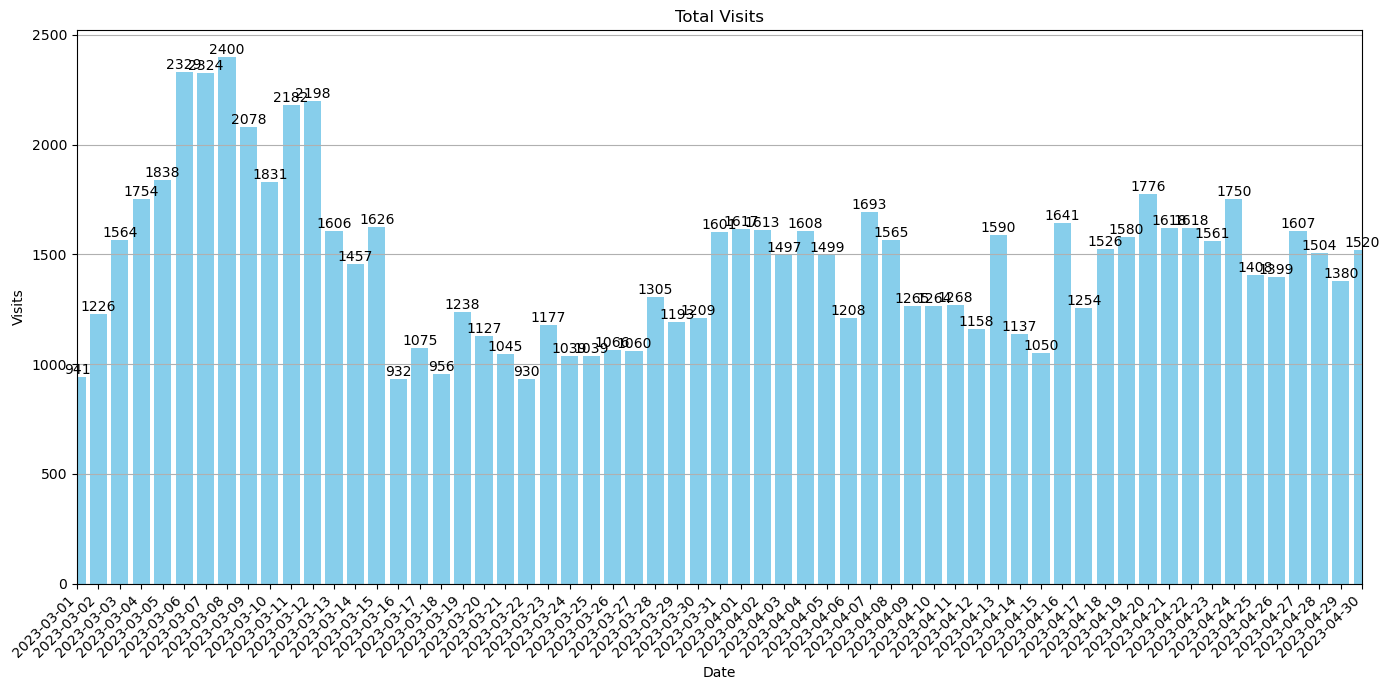

In [97]:
# График Итоговые визиты
grouped_data = filtered_df.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(grouped_data['date_group'], grouped_data['visits'], color='skyblue')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.title('Total Visits')
plt.xticks(grouped_data['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Total Visits.png'))
plt.show()

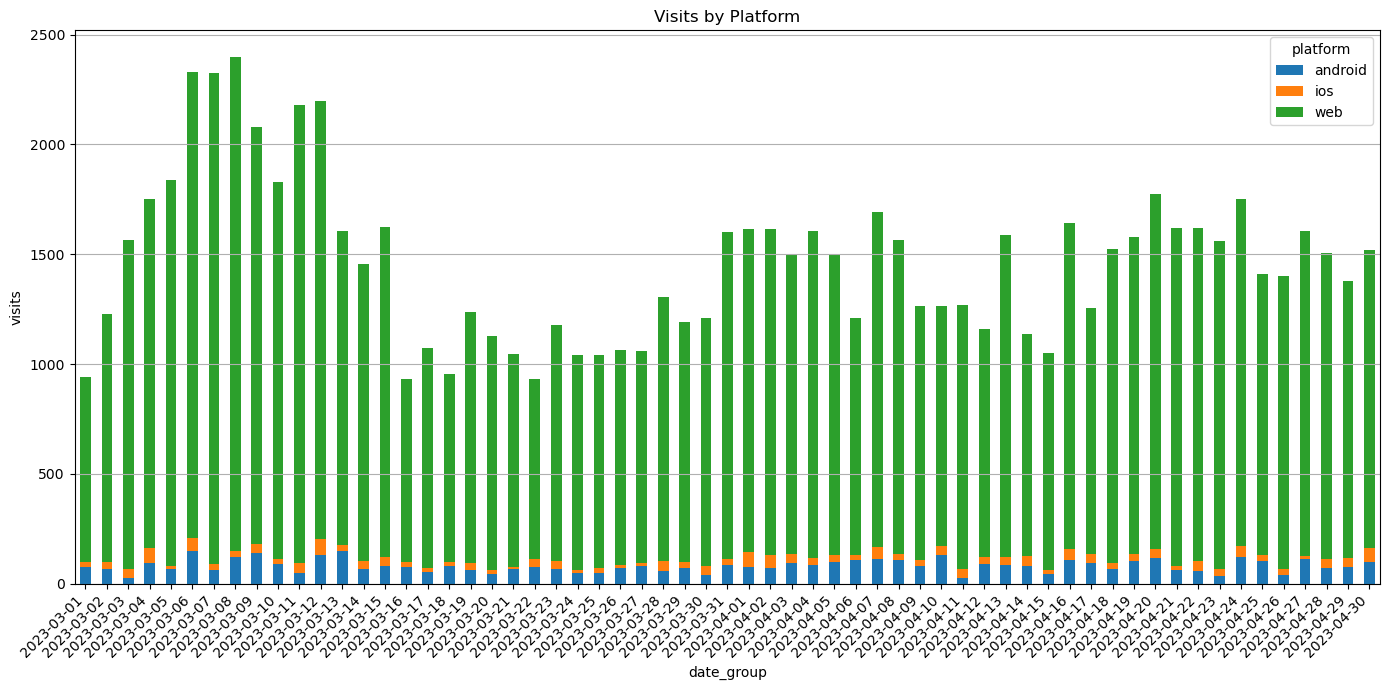

In [98]:
# График Итоговые визиты с разбивкой по платформам
pivot_df = filtered_df.pivot_table(values='visits', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('visits')
ax.set_title('Visits by Platform')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
ax.set_xticks(range(len(pivot_df.index)))
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Visits_by_platform.png'))
plt.show()

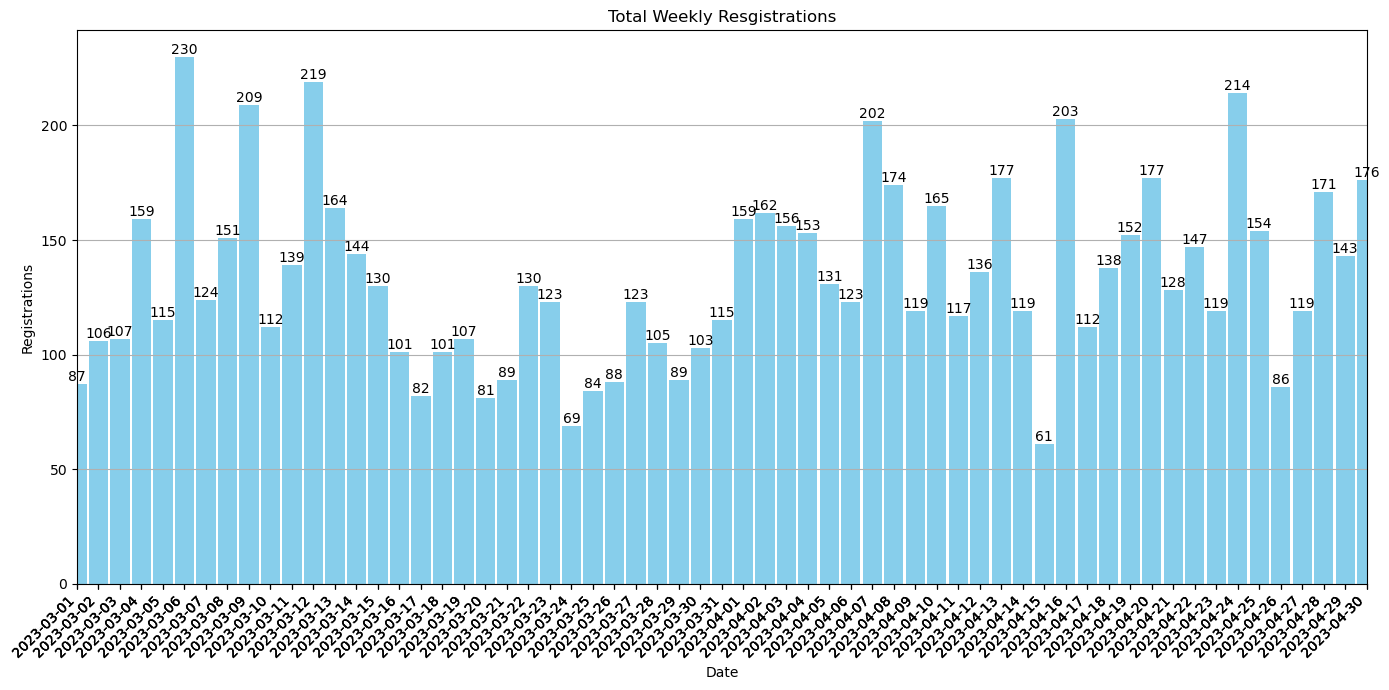

In [99]:
# График Итоговые регистрации
filtered_df_registrations = filtered_df.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(14, 7))
bars = plt.bar(filtered_df_registrations['date_group'], filtered_df_registrations['registrations'], color='skyblue', width=0.9)
plt.xlabel('Date')
plt.ylabel('Registrations')
plt.title('Total Weekly Resgistrations')
plt.xticks(filtered_df['date_group'], rotation=45, ha='right')
plt.grid(axis='y')

plt.xlim(min(grouped_data['date_group']), max(grouped_data['date_group']))

# Добавляем подписи к столбикам по количеству регистраций
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Total Weekly Resgistrations'))
plt.show()

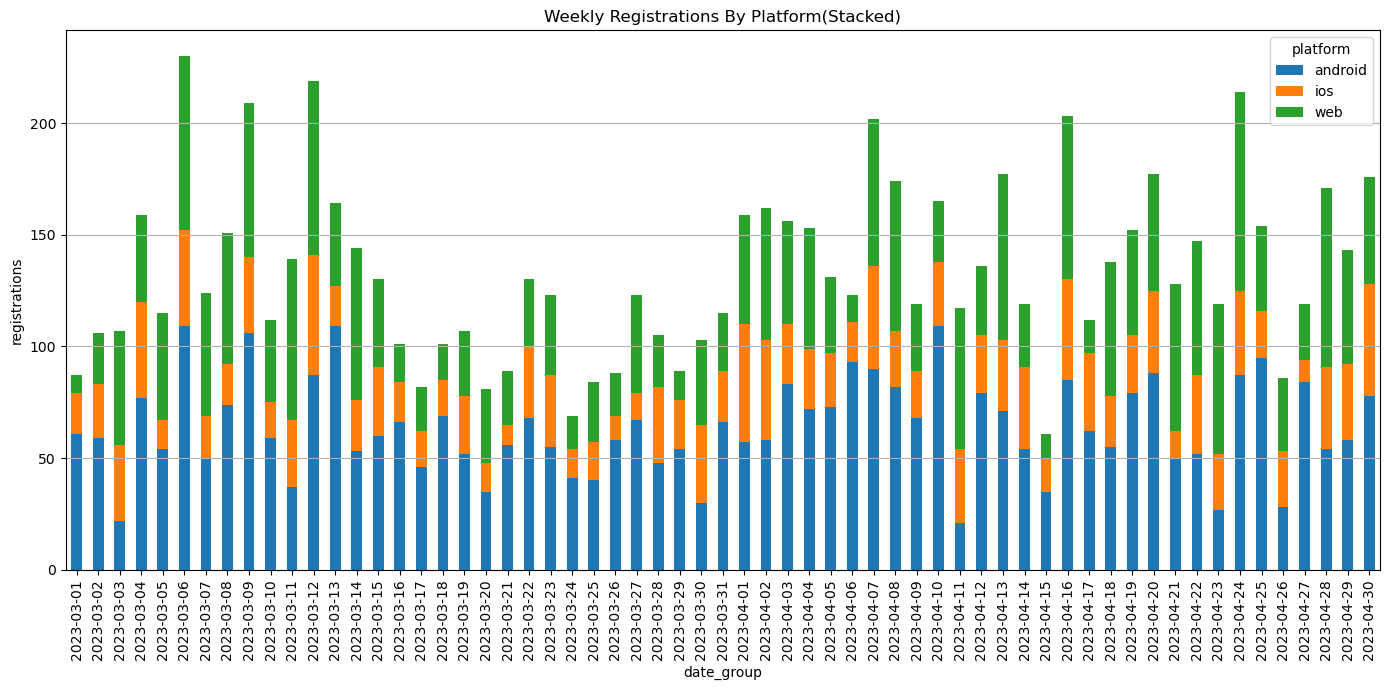

In [100]:
# График Итоговые регистрации с разбивкой по платформе
filtered_df = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-04-30')]

# Преобразуем данные так, чтобы получить сумму посещений для каждой платформы в каждую дату
pivot_df = filtered_df.pivot_table(values='registrations', index='date_group', columns='platform', aggfunc='sum', fill_value=0)

fig, ax = plt.subplots(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('date_group')
ax.set_ylabel('registrations')
ax.set_title('Weekly Registrations By Platform(Stacked)')
ax.set_xticks(range(len(pivot_df.index)))

# Устанавливаем пределы оси x, чтобы убрать пустое место перед первым столбцом и после последнего
ax.set_xlim(-0.5, len(pivot_df.index)-0.5)

ax.grid(axis='y')

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Weekly Registrations By Platform'))
plt.show()

In [101]:
# График Итоговые конверсии 
# Преобразование столбца даты в формат datetime
result_df['date_group'] = pd.to_datetime(result_df['date_group'])

# Извлечение года и месяца и добавление их в отдельные столбцы
result_df['year_month'] = result_df['date_group'].dt.to_period('M')

# Группировка данных по годам и месяцам и расчет средней конверсии за месяц
monthly_avg_conversion = result_df.groupby('year_month')['conversion'].mean().reset_index()

# Преобразование конверсии в проценты
monthly_avg_conversion['conversion'] = monthly_avg_conversion['conversion']

print(monthly_avg_conversion)

  year_month  conversion
0    2023-03   53.388621
1    2023-04   55.024505
2    2023-05   54.633910
3    2023-06   51.625563
4    2023-07   45.285627
5    2023-08   51.280671


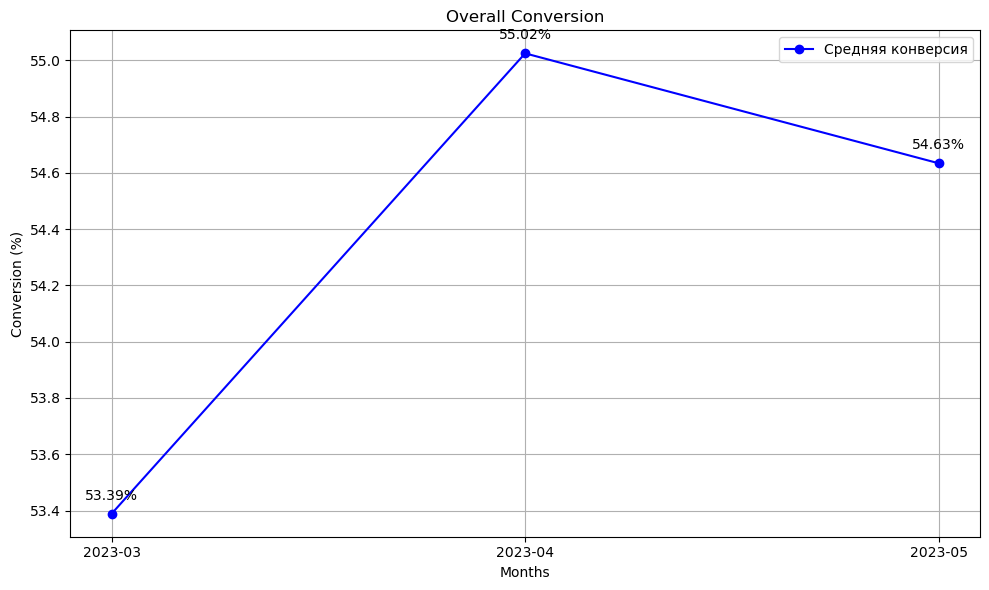

In [102]:
monthly_avg_conversion['year_month'] = monthly_avg_conversion['year_month'].astype(str)
filtered_data = monthly_avg_conversion[(monthly_avg_conversion['year_month'] >= '2023-03') & (monthly_avg_conversion['year_month'] <= '2023-05')]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data['year_month'], filtered_data['conversion'], marker='o', linestyle='-', color='b', label='Средняя конверсия')

for i, txt in enumerate(filtered_data['conversion']):
    plt.annotate(f'{txt:.2f}%', (filtered_data['year_month'].iloc[i], filtered_data['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Months')
plt.ylabel('Conversion (%)')
plt.title('Overall Conversion')
plt.grid(True) 
plt.legend() 

plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Overall Conversion'))
plt.show()

C:\Users\a.r.ziborov\AppData\Local\Temp\ipykernel_3276\3867454635.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  android_df.loc[:, 'conversion'] = android_df['conversion']
C:\Users\a.r.ziborov\AppData\Local\Temp\ipykernel_3276\3867454635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ios_df.loc[:, 'conversion'] = ios_df['conversion']
C:\Users\a.r.ziborov\AppData\Local\Temp\ipykernel_3276\3867454635.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

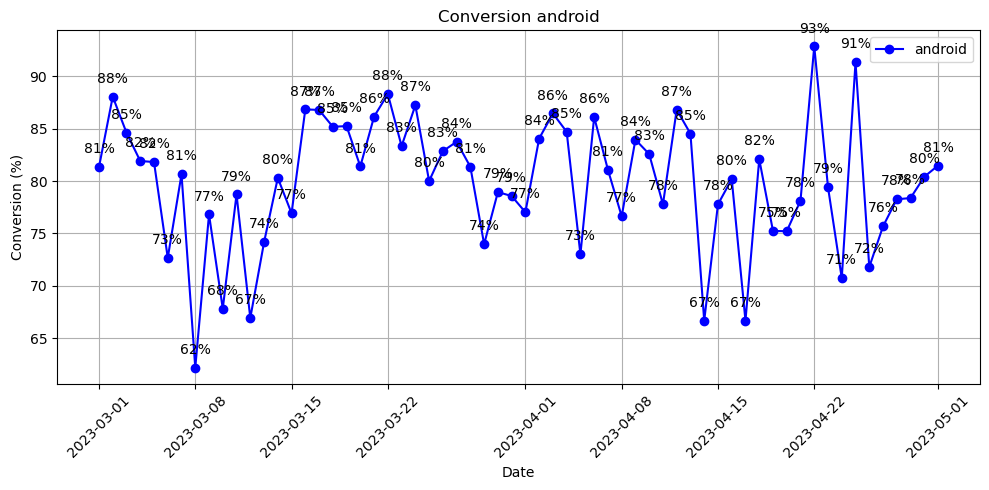

In [103]:
# Конверсия по каждой платформе
filtered_df_conversion = result_df[(result_df['date_group'].astype(str) >= '2023-03-01') & (result_df['date_group'].astype(str) <= '2023-05-01')]

# Отфильтруем 3 датасета по каждой из платформ
android_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'android']
android_df.loc[:, 'conversion'] = android_df['conversion']

ios_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'ios']
ios_df.loc[:, 'conversion'] = ios_df['conversion']

web_df = filtered_df_conversion[filtered_df_conversion['platform'] == 'web']
web_df.loc[:, 'conversion'] = web_df['conversion']
plt.figure(figsize=(10, 5))
plt.plot(android_df['date_group'], android_df['conversion'], marker='o', linestyle='-', color='blue', label='android')

for i, txt in enumerate(android_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (android_df['date_group'].iloc[i], android_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conversion android')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion android'))
plt.show()

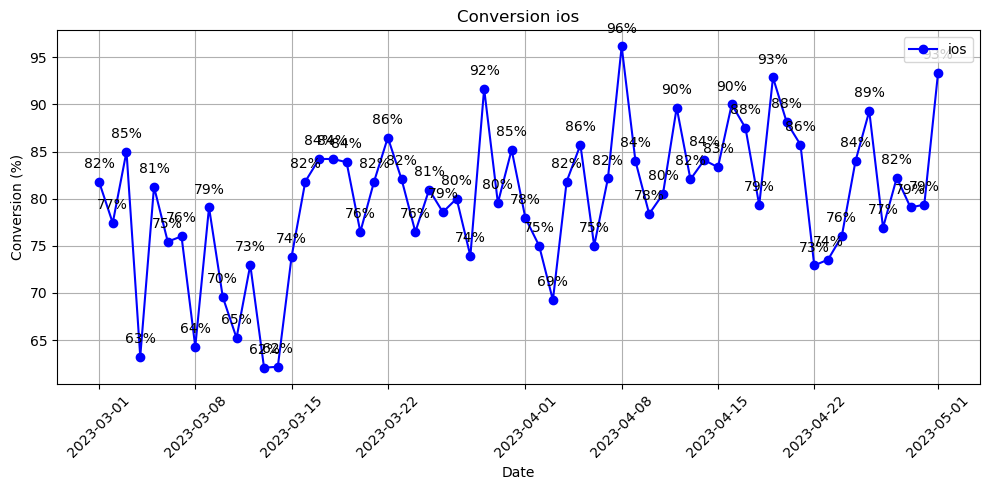

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(ios_df['date_group'], ios_df['conversion'], marker='o', linestyle='-', color='blue', label='ios')

for i, txt in enumerate(ios_df['conversion']):
    plt.annotate(f'{txt:.0f}%', (ios_df['date_group'].iloc[i], ios_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion ios')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion ios'))
plt.show()

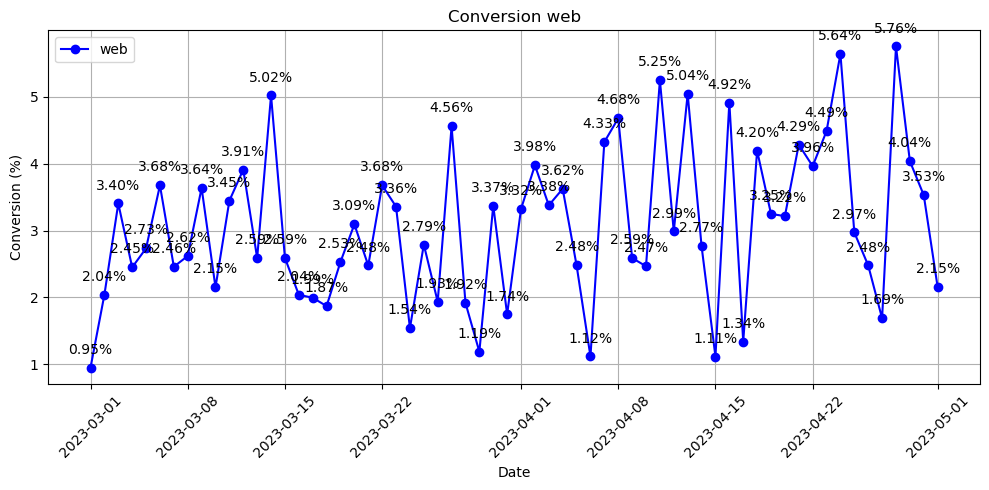

In [105]:
plt.figure(figsize=(10, 5))
plt.plot(web_df['date_group'], web_df['conversion'], marker='o', linestyle='-', color='blue', label='web')

for i, txt in enumerate(web_df['conversion']):
    plt.annotate(f'{txt:.2f}%', (web_df['date_group'].iloc[i], web_df['conversion'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')


plt.title('Conversion web')
plt.xlabel('Date')
plt.ylabel('Conversion (%)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_folder, 'Conversion web'))
plt.show()

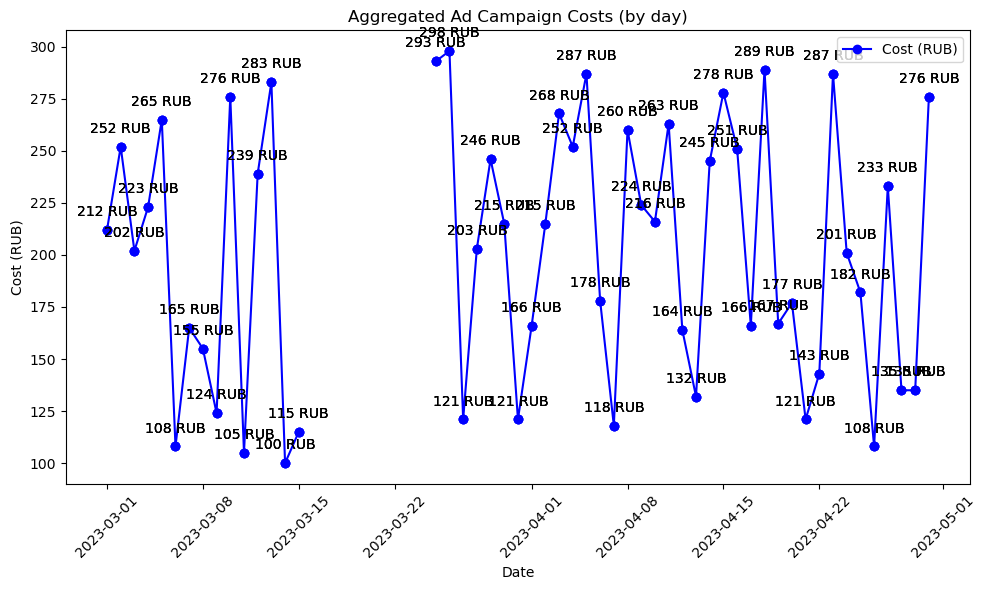

In [106]:
# График стоимости реклам
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['date_group'], filtered_df['cost'], marker='o', linestyle='-', label='Cost (RUB)', color='blue')

for i, txt in enumerate(filtered_df['cost']):
    plt.annotate(f'{txt:.0f} RUB', (filtered_df['date_group'].iloc[i], filtered_df['cost'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Aggregated Ad Campaign Costs (by day)')
plt.xlabel('Date')
plt.ylabel('Cost (RUB)')
plt.xticks(rotation=45)
plt.legend()  
plt.tight_layout()  
plt.savefig(os.path.join(save_folder, 'Aggregated Ad Campaign Costs (by day)'))
plt.show()

In [107]:
campaign_periods = ads_df.groupby(['utm_campaign']).agg(start = ('date_group', 'min'), end = ('date_group', 'max')).reset_index()
campaign_periods

,utm_campaign,start,end
0,advanced_algorithms_series,2023-03-01,2023-03-15
1,intro_to_python_course,2023-08-06,2023-09-17
2,ui_ux_design_drive,2023-05-19,2023-06-09
3,virtual_reality_workshop,2023-03-25,2023-05-06
4,women_in_tech_symposium,2023-06-21,2023-07-26


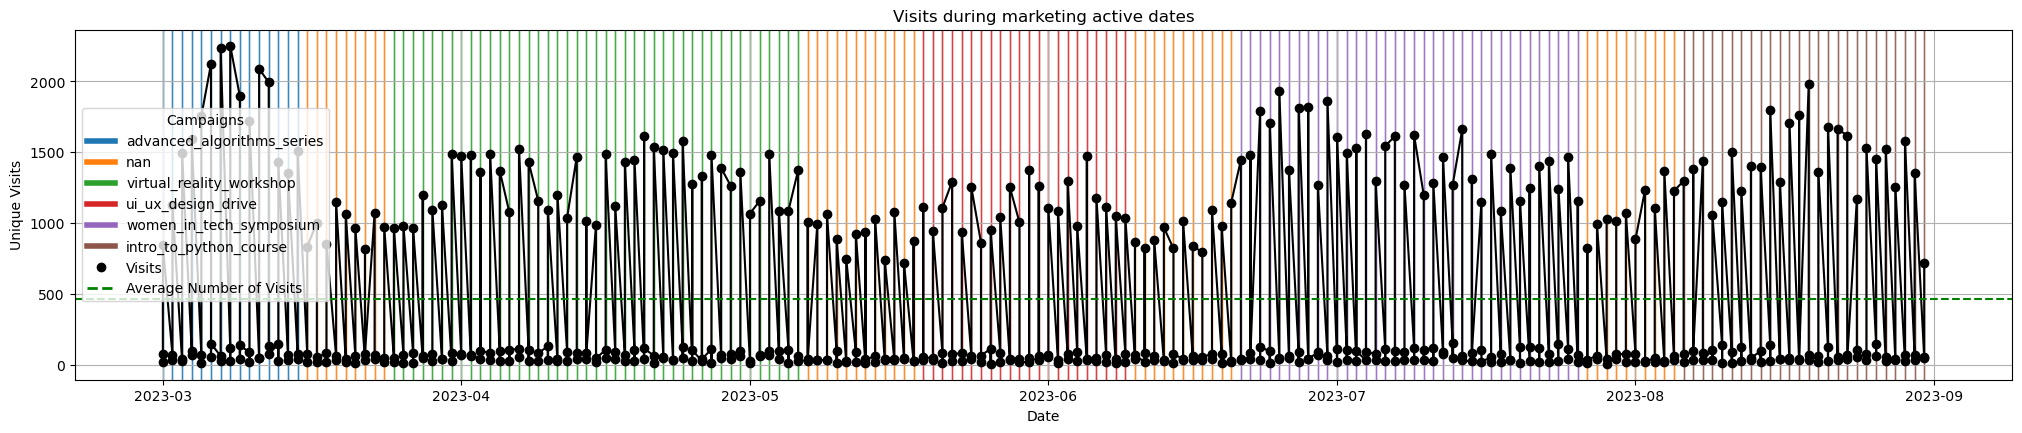

In [108]:
plt.figure(figsize=(25, 10))

# Цвета для рекламных кампаний
campaign_colors = dict(zip(result_df['utm_campaign'].unique(), plt.cm.tab10.colors[:len(result_df['utm_campaign'].unique())]))

plt.subplot(2, 1, 1)

# График визитов
plt.plot(result_df['date_group'], result_df['visits'], marker='o', color='black', label='Visits')
plt.axhline(y=np.nanmean(result_df['visits']), linestyle='dashed', color='green', label='Average Number of Visits')

# Добавление областей для рекламных кампаний
for _, row in result_df.iterrows():
    plt.axvspan(row['date_group'], row['date_group'], color=campaign_colors[row['utm_campaign']], alpha=0.5)

# Добавление легенды для уникальных рекламных кампаний
handles = [plt.Line2D([0], [0], color=campaign_colors[campaign], lw=4, label=campaign) for campaign in campaign_colors]
handles.append(plt.Line2D([0], [0], color='black', marker='o', lw=0, label='Visits'))
handles.append(plt.Line2D([0], [0], linestyle='dashed', color='green', lw=2, label='Average Number of Visits'))

plt.legend(handles=handles, title='Campaigns')

plt.title('Visits during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Unique Visits')
plt.grid(True)

plt.savefig(os.path.join(save_folder, 'Visits during marketing active dates.png'))
plt.show()

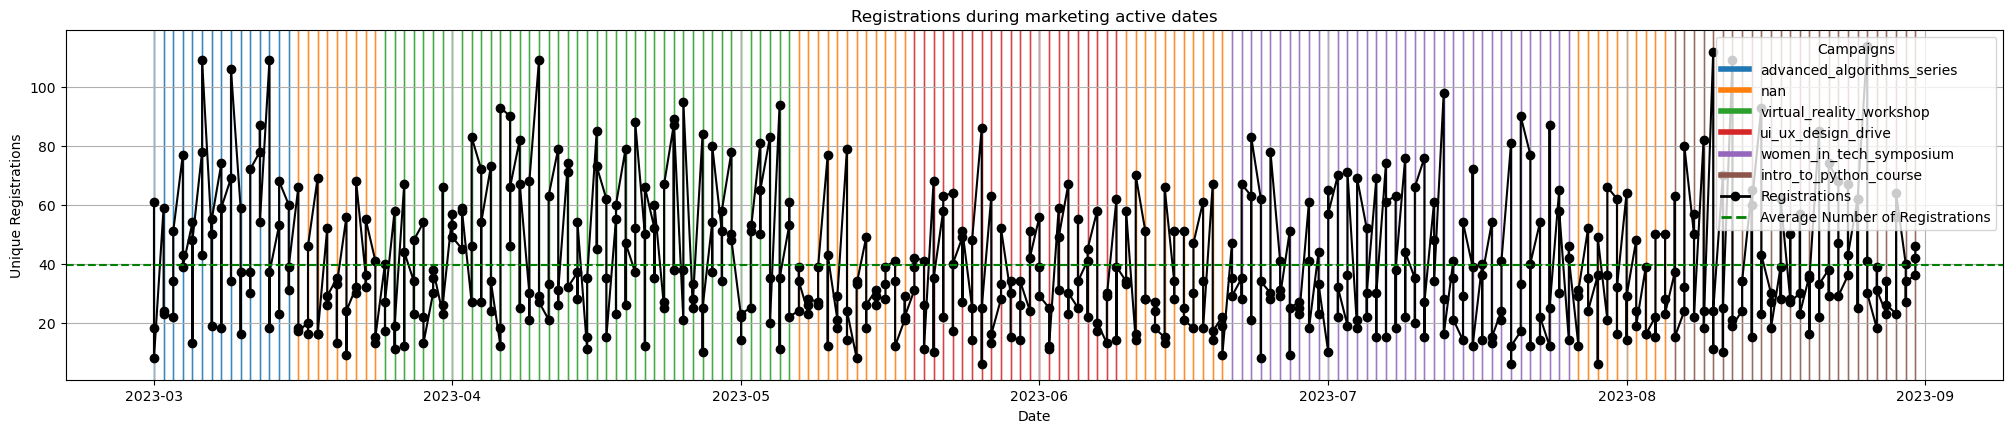

In [109]:
plt.figure(figsize=(25, 10))

# Цвета для рекламных кампаний
campaign_colors = dict(zip(result_df['utm_campaign'].unique(), plt.cm.tab10.colors[:len(result_df['utm_campaign'].unique())]))

plt.subplot(2, 1, 2)  # Изменил на subplot(2, 1, 2) для второго графика

# График регистраций
plt.plot(result_df['date_group'], result_df['registrations'], marker='o', color='black', label='Registrations')
plt.axhline(y=np.nanmean(result_df['registrations']), linestyle='dashed', color='green', label='Average Number of Registrations')

# Добавление областей для рекламных кампаний
for _, row in result_df.iterrows():
    plt.axvspan(row['date_group'], row['date_group'], color=campaign_colors[row['utm_campaign']], alpha=0.5)

# Добавление легенды только для уникальных рекламных кампаний
handles = [plt.Line2D([0], [0], color=campaign_colors[campaign], lw=4) for campaign in campaign_colors]
handles.append(plt.Line2D([0], [0], color='black', lw=2, marker='o', label='Registrations'))
handles.append(plt.Line2D([0], [0], color='green', linestyle='dashed', lw=2, label='Average Number of Registrations'))

plt.legend(handles, list(campaign_colors.keys()) + ['Registrations', 'Average Number of Registrations'], title='Campaigns')

plt.title('Registrations during marketing active dates')
plt.xlabel('Date')
plt.ylabel('Unique Registrations')
plt.grid(True)

plt.savefig(os.path.join(save_folder, 'Registrations during marketing active dates.png'))
plt.show()